In [1]:
#### imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammainc

from astropy import units as u
from astropy import constants as c
from astropy.io import fits
# plt.style.use("my_latex_standard2")

# Gala
import gala.potential as gp
from gala.units import galactic

from colossus.cosmology import cosmology
from colossus.halo import profile_einasto

import agama

### Milky Way model

This Milky Way model consists of a DM halo following an Einasto profile, one exponential disc and possibly a broken power-law bulge. The total mass is $10^{12}\mathrm{M}_\odot$. We aim to get the enclosed mass at $100$ kpc similar to the fits of the Sagittarius (Vasiliev+ 2021) and OC (Koposov+ 2023) streams. The inner rotation curve should follow the McMillan MW potential.

In [2]:
@u.quantity_input
def exponential_disc_dens(
                    R: u.kpc, 
                    z: u.kpc, 
                    R_d: u.kpc = 3, 
                    z_d: u.kpc = 0.5, 
                    Sigma0: u.Msun / u.kpc**2 = 808                
    ):
    """Density of the exponential disc."""
    return Sigma0/(2*z_d) * np.exp(-np.abs(z)/z_d - R/R_d)


def exponential_disc_encl_mass(
                    R: u.kpc, 
                    z: u.kpc, 
                    R_d: u.kpc = 3.5*u.kpc, 
                    z_d: u.kpc = 0.500*u.kpc, 
                    Sigma0: u.Msun / u.pc**2 = 750 *u.Msun / u.pc**2               
    ):
    """Enclosed mass of the exponential disc."""
    return 2*np.pi*Sigma0.to(u.Msun/u.kpc**2) * (R_d**2 - R_d*(R+R_d)*np.exp(-R/R_d)) 

Sigma0 = 750 * u.Msun / u.pc**2
R_d = 3.5 * u.kpc 
total_disc_mass = 2 * np.pi * Sigma0.to(u.Msun/u.kpc**2) * R_d**2
print(f'the total disc mass is {total_disc_mass:.2e}')

the total disc mass is 5.77e+10 solMass


In [3]:
### MW mass measurements (based on Koposov+ 2023)

# Koposov+ 2023
# load profile from K23
filename = './stad551_supplemental_file/from_denis/oblate_mass_table.fits'
with fits.open(filename) as hdul:
    table = hdul[1]

    r_K23 = table.data['r_arr'] * u.kpc
    M_K23 = table.data['M_arr'] * 1e10 * u.Msun
if 0: table.header

## other measurements

# Vasiliev+ 2021
r_V21 = 100 * u.kpc
M_V21 = 5.6e11 * u.Msun
eM_V21 = 0.4e11 * u.Msun

r2_V21 = 50 * u.kpc
M2_V21 = 3.85e11 * u.Msun
eM2_V21 = 0.1e11 * u.Msun

# Gibbons+ 2014
r_G14 = 100 * u.kpc
M_G14 = 4e11 * u.Msun
eM_G14 = 0.7e11 * u.Msun

# Fardal+ 2019
r_F19 = 100 * u.kpc
M_F19 = 7.1e11 * u.Msun
eM_F19 = 0.7e11 * u.Msun

# Deason+ 2021
r_D21 = 100 * u.kpc
M_D21 = 6.07e11 * u.Msun
eM_D21 = np.sqrt(0.2e11**2 + 1.21e11**2) * u.Msun

# # all vals
r_all = [r_V21, r2_V21, r_G14, r_F19, r_D21]
M_all = [M_V21, M2_V21, M_G14, M_F19, M_D21]
eM_all = [eM_V21, eM2_V21, eM_G14, eM_F19, eM_D21]
labels = ['V21', 'V21', 'G14', 'F19', 'D21']
zorders = [100, 100, 100, 101, 99]
colors = ['C0', 'C0', 'C1', 'C2', 'C3']

In [4]:
cosmology.setCosmology('planck18')
cosmo = cosmology.getCurrent()
h = cosmo.h
p_einasto = profile_einasto.EinastoProfile(M=0.8E12, c=15.0, z=0.0, mdef='vir')
rho_ein, r_ein, alpha = p_einasto.getParameterArray()
n_ein = 1/alpha
rho_ein = rho_ein * u.Msun*u.kpc**(-3) / cosmo.h**2
r_ein = r_ein * u.kpc * cosmo.h

print(f'alpha = {alpha:.2f}\nn = {n_ein:.2f}\nrho_ein = {rho_ein:.2e}\nr_ein = {r_ein:.2f}')

alpha = 0.16
n = 6.22
rho_ein = 8.64e+06 solMass / kpc3
r_ein = 8.51 kpc


In [5]:
print(fr'rvir = {r_ein*15:.2f} but we take 122')
print(fr'virv = {p_einasto.circularVelocity((r_ein*15).value)*u.km/u.s:.2f}, we take 149')

rvir = 127.58 kpc but we take 122
virv = 148.29 km / s, we take 149


In [6]:
### bulge
from gala.potential import MilkyWayPotential

bulge = gp.HernquistPotential(m=1e10, c=1., units=galactic)

In [7]:
### Nico's MW model
nico_halo = gp.HernquistPotential(m=1.47e12*u.Msun, c=40.83*u.kpc, units=galactic)
nico_bulge= gp.HernquistPotential(m=0.7e10*u.Msun, c=0.7*u.kpc, units=galactic)

nico_pot = gp.CCompositePotential()
nico_pot['halo'] = nico_halo
nico_pot['bulge'] = nico_bulge  



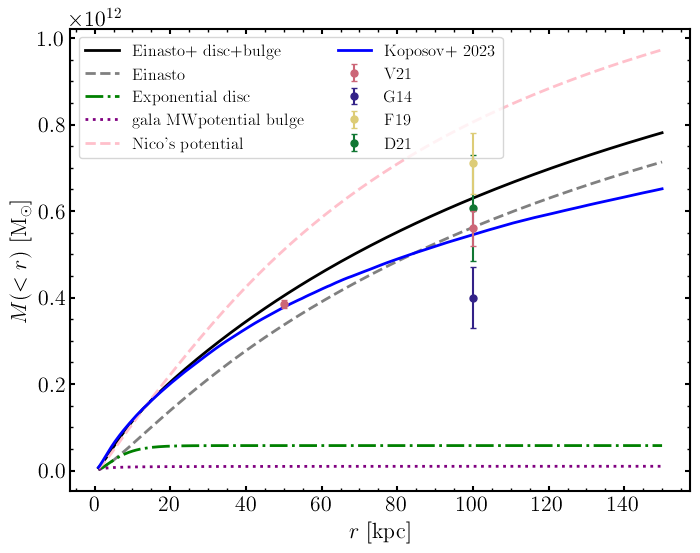

In [8]:

## plot enclosed mass profiles and compare to fitting results 

r = np.arange(1, 150.1, 1.) * u.kpc
M_ein = p_einasto.enclosedMass(r.value) * u.Msun
r = np.arange(1, 150.1, 1.) * u.kpc
M_disc = exponential_disc_encl_mass(r, 0*u.kpc)

xyz = np.zeros((3, len(r)))
xyz[0] = r
M_bulge = bulge.mass_enclosed(xyz)

M_nico = nico_pot.mass_enclosed(xyz) + M_disc

fig, ax= plt.subplots(1,1, figsize=(8,6))

ax.plot(r, M_ein+M_disc+M_bulge, label='Einasto+ disc+bulge', color='k', lw=2)
ax.plot(r, M_ein, label='Einasto', ls='--', color='grey', lw=2)
ax.plot(r, M_disc, label='Exponential disc', ls='-.', color='g', lw=2)
ax.plot(r, M_bulge, label='gala MWpotential bulge', ls=':', color='purple', lw=2)
ax.plot(r, M_nico, label="Nico's potential", ls='--', color='pink', lw=2)

ax.plot(r_K23, M_K23, label='Koposov+ 2023', color='b', ls='-', lw=2)

for r_ex, M_ex, eM_ex, label_ex, zorder, color in zip(r_all, M_all, eM_all, labels, zorders, colors):
    ax.errorbar(r_ex, M_ex, yerr=eM_ex, marker='o', ms=5, ls='none', c=color, label=label_ex, capsize=2, zorder=zorder)
ax.set_xlabel('$r$ [kpc]')
ax.set_ylabel(r'$M(<r)$ [$\mathrm{M}_\odot$]')
leg_handles, leg_labels = ax.get_legend_handles_labels()
leg_handles.pop(-4)
leg_labels.pop(-4)
ax.legend(leg_handles, leg_labels, ncol=2, fontsize=12)


Text(0, 0.5, '$v_\\mathrm{rot}$ [km/s]')

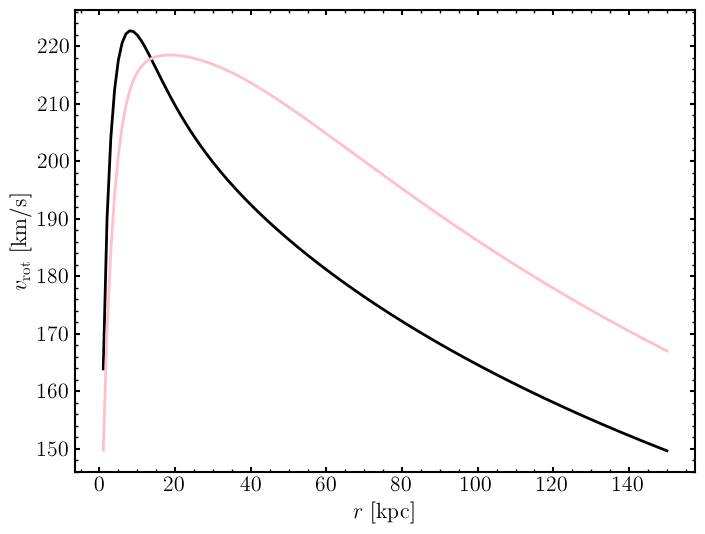

In [9]:
r = np.arange(1, 150.1, 1.)
M_ein = p_einasto.enclosedMass(r) * u.Msun
r = np.arange(1, 150.1, 1.) * u.kpc
M_disc = exponential_disc_encl_mass(r, 0*u.kpc)

vrot = np.sqrt(c.G * (M_ein+M_disc+M_bulge) / r).to(u.km/u.s)
vrot_nico = np.sqrt(c.G * M_nico / r).to(u.km/u.s)

fig, ax= plt.subplots(1,1, figsize=(8,6))

ax.plot(r, vrot, color='k', lw=2)
ax.plot(r, vrot_nico, color='pink', lw=2)
ax.set_xlabel('$r$ [kpc]')
ax.set_ylabel(r'$v_\mathrm{rot}$ [km/s]')



### LMC model


The LMC model consists of an Einasto profile halo and an exponential disc. The total mass is scaled to be 20% of the MW mass. The disc is chosen to match the inner rotation curve measurement from xxx. The disc orientation should be yyy.


In [10]:
### LMC einasto
cosmology.setCosmology('planck18')
cosmo = cosmology.getCurrent()
h = cosmo.h
p_einasto_lmc = profile_einasto.EinastoProfile(M=1E11, c=15.0, z=0.0, mdef='vir')
rho_ein_lmc, r_ein_lmc, alpha_lmc = p_einasto_lmc.getParameterArray()
n_ein_lmc = 1/alpha_lmc
rho_ein_lmc = rho_ein_lmc * u.Msun*u.kpc**(-3) / cosmo.h**2
r_ein_lmc = r_ein_lmc * u.kpc * cosmo.h

print(f'alpha = {alpha_lmc:.2f}\nn = {n_ein_lmc:.2f}\nrho_ein = {rho_ein_lmc:.2e}\nr_ein = {r_ein_lmc:.2f}')

alpha = 0.16
n = 6.32
rho_ein = 8.56e+06 solMass / kpc3
r_ein = 4.25 kpc


In [11]:
## LMC exponential disc
M_tot_lmc = 3.1e9 * u.Msun
R_d_lmc = 1.7 * u.kpc 
Sigma0_lmc = (M_tot_lmc / (2 * np.pi * R_d_lmc**2)).to(u.Msun/u.pc**2)

print(f'Sigma0 = {Sigma0_lmc:.2f}')

def exponential_disc_encl_mass(
                    R: u.kpc, 
                    R_d: u.kpc, 
                    Sigma0: u.Msun / u.pc**2             
    ):
    """Enclosed mass of the exponential disc."""
    return 2*np.pi*Sigma0.to(u.Msun/u.kpc**2) * (R_d**2 - R_d*(R+R_d)*np.exp(-R/R_d)) 


print(f'the total disc mass is {M_tot_lmc:.2e}')


Sigma0 = 170.72 solMass / pc2
the total disc mass is 3.10e+09 solMass


In [12]:
# convert into G=1 units
astronomicalG = 0.0000043009125 * (u.km/u.s)**2 * u.kpc / u.Msun # gravitational constant, (km/s)^2 * kpc / Msun
rvir          = 122. * u.kpc # kpc
vvir          = 149. * u.km/u.s # km/s (circular velocity at virial radius)
mvir          = vvir * vvir * rvir / astronomicalG

print(f'LMC virial disc scale length is {R_d_lmc/rvir:.3f}.')
print(f'LMC virial disc scale height is {0.2 * R_d_lmc/rvir:.3f}.')
print(f'LMC virial disc mass is {M_tot_lmc/mvir:.3f}.')



LMC virial disc scale length is 0.014.
LMC virial disc scale height is 0.003.
LMC virial disc mass is 0.005.


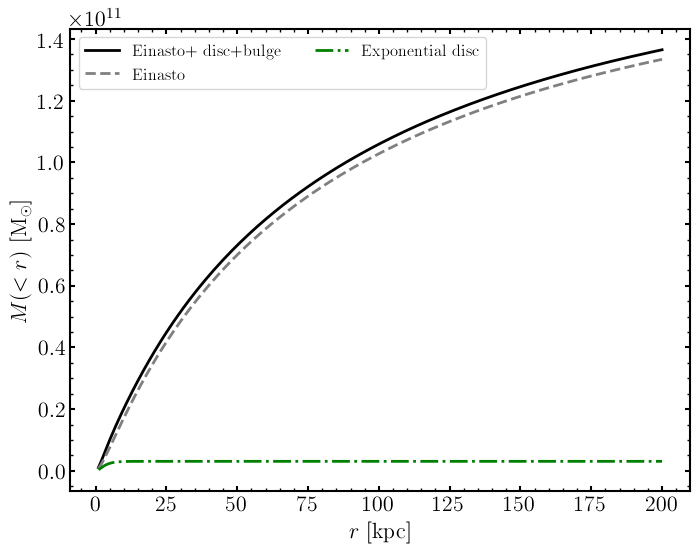

In [13]:

## plot LMC enclosed mass profiles

r_lmc = np.arange(1, 200.1, 1.) * u.kpc
M_ein_lmc = p_einasto_lmc.enclosedMass(r_lmc.value) * u.Msun
M_disc_lmc = exponential_disc_encl_mass(r_lmc, R_d=R_d_lmc, Sigma0=Sigma0_lmc)


fig, ax= plt.subplots(1,1, figsize=(8,6))

ax.plot(r_lmc, M_ein_lmc+M_disc_lmc, label='Einasto+ disc+bulge', color='k', lw=2)
ax.plot(r_lmc, M_ein_lmc, label='Einasto', ls='--', color='grey', lw=2)
ax.plot(r_lmc, M_disc_lmc, label='Exponential disc', ls='-.', color='g', lw=2)

ax.set_xlabel('$r$ [kpc]')
ax.set_ylabel(r'$M(<r)$ [$\mathrm{M}_\odot$]')
leg_handles, leg_labels = ax.get_legend_handles_labels()
ax.legend(leg_handles, leg_labels, ncol=2, fontsize=12)


Text(0, 0.5, '$v_\\mathrm{rot}$ [km/s]')

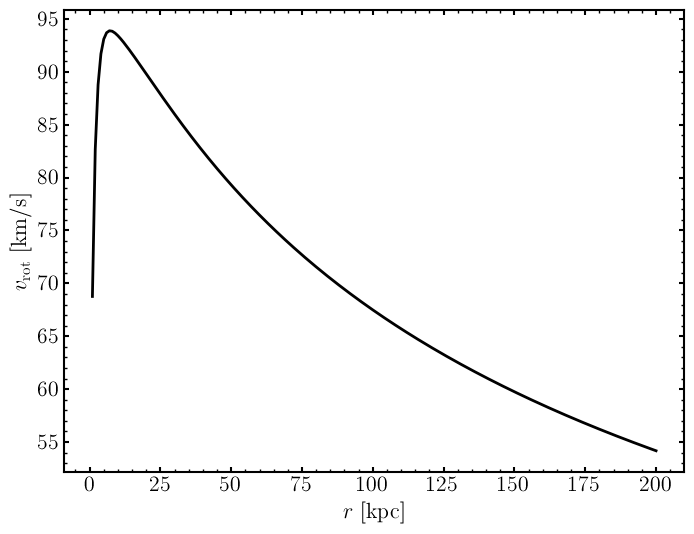

In [14]:
vrot_lmc = np.sqrt(c.G * (M_ein_lmc+M_disc_lmc) / r_lmc).to(u.km/u.s)

fig, ax= plt.subplots(1,1, figsize=(8,6))

ax.plot(r_lmc, vrot_lmc, color='k', lw=2)

ax.set_xlabel('$r$ [kpc]')
ax.set_ylabel(r'$v_\mathrm{rot}$ [km/s]')



### Particle numbers

| Component | Mass | fraction | number of particles |
| --------- | ---- | --- |------------------- |
| MW halo   | 1e12 | 0.7931 | 1.6e9 |
| MW disc   | 5.77e10 | 0.0458 | 9.2e7 |
| LMC halo  | 2e11? |0.1586 | 3.2e8 |
| LMC disc  | 3.1e9 |  0.0025  | 4.9e6 |
| total | 1.26e12 | 1  | 2e12 |

In [8]:
MW_mh = 1e12
MW_md = 5.77e10
LMC_mh = 2e11
LMC_md = 3.1e9

total = MW_mh + MW_md + LMC_mh + LMC_md
print(f'The total mass is {total:.2e}')

print(f'The MW halo to total ratio is {MW_mh/total:.4f}.')
print(f'The MW disc to total ratio is {MW_md/total:.4f}.')
print(f'The LMC halo to total ratio is {LMC_mh/total:.4f}.')
print(f'The LMC disc to total ratio is {LMC_md/total:.4f}.')

print (f'Sum of all ratios is {MW_mh/total + MW_md/total + LMC_mh/total + LMC_md/total:.4f}.')

partnum = 2e9 
mw_ph = partnum*MW_mh/total
mw_pd = partnum*MW_md/total
lmc_ph = partnum*LMC_mh/total
lmc_pd = partnum*LMC_md/total

print(f'The MW halo should have {mw_ph:.1e} particles.')
print(f'The MW disc should have {mw_pd:.1e} particles.')
print(f'The LMC halo should have {lmc_ph:.1e} particles.')
print(f'The LMC disc should have {lmc_pd:.1e} particles.')

print(f"There are {mw_ph+mw_pd+lmc_ph+lmc_pd} total particles")


The total mass is 1.26e+12
The MW halo to total ratio is 0.7931.
The MW disc to total ratio is 0.0458.
The LMC halo to total ratio is 0.1586.
The LMC disc to total ratio is 0.0025.
Sum of all ratios is 1.0000.
The MW halo should have 1.6e+09 particles.
The MW disc should have 9.2e+07 particles.
The LMC halo should have 3.2e+08 particles.
The LMC disc should have 4.9e+06 particles.
There are 1999999999.9999998 total particles
